In [66]:
import os
import random
from deap import base, creator, tools
from ga_functions import merge_rules, load_solomon_txt
import matplotlib.pyplot as plt
import numpy as np

In [67]:

def ind2route(individual, instance):
    '''gavrptw.core.ind2route(individual, instance)'''
    route = []
    vehicle_capacity = instance['vehicle_capacity']
    depart_due_time = instance['depart']['due_time']
    # Initialize a sub-route
    sub_route = []
    vehicle_load = 0
    elapsed_time = 0
    last_customer_id = 0
    for customer_id in individual:
        # Update vehicle load
        demand = instance[f'customer_{customer_id}']['demand']
        updated_vehicle_load = vehicle_load + demand
        # Update elapsed time
        service_time = instance[f'customer_{customer_id}']['service_time']
        return_time = instance['distance_matrix'][customer_id][0]
        updated_elapsed_time = elapsed_time + \
            instance['distance_matrix'][last_customer_id][customer_id] + service_time + return_time
        # Validate vehicle load and elapsed time
        if (updated_vehicle_load <= vehicle_capacity) and (updated_elapsed_time <= depart_due_time):
            # Add to current sub-route
            sub_route.append(customer_id)
            vehicle_load = updated_vehicle_load
            elapsed_time = updated_elapsed_time - return_time
        else:
            # Save current sub-route
            route.append(sub_route)
            # Initialize a new sub-route and add to it
            sub_route = [customer_id]
            vehicle_load = demand
            elapsed_time = instance['distance_matrix'][0][customer_id] + service_time
        # Update last customer ID
        last_customer_id = customer_id
    if sub_route != []:
        # Save current sub-route before return if not empty
        route.append(sub_route)
    return route

def print_route(route, merge=False):
    '''gavrptw.core.print_route(route, merge=False)'''
    route_str = '0'
    sub_route_count = 0
    for sub_route in route:
        sub_route_count += 1
        sub_route_str = '0'
        for customer_id in sub_route:
            sub_route_str = f'{sub_route_str} - {customer_id}'
            route_str = f'{route_str} - {customer_id}'
        sub_route_str = f'{sub_route_str} - 0'
        if not merge:
            print(f'  Vehicle {sub_route_count}\'s route: {sub_route_str}')
        route_str = f'{route_str} - 0'
    if merge:
        print(route_str)


def eval_vrptw(individual, instance, unit_cost=1.0, init_cost=0, wait_cost=0, delay_cost=0):
    '''gavrptw.core.eval_vrptw(individual, instance, unit_cost=1.0, init_cost=0, wait_cost=0,
        delay_cost=0)'''
    total_cost = 0
    route = ind2route(individual, instance)
    total_cost = 0
    for sub_route in route:
        sub_route_time_cost = 0
        sub_route_distance = 0
        elapsed_time = 0
        last_customer_id = 0
        for customer_id in sub_route:
            # Calculate section distance
            distance = instance['distance_matrix'][last_customer_id][customer_id]
            # Update sub-route distance
            sub_route_distance = sub_route_distance + distance
            # Calculate time cost
            arrival_time = elapsed_time + distance
            time_cost = wait_cost * max(instance[f'customer_{customer_id}']['ready_time'] - \
                arrival_time, 0) + delay_cost * max(arrival_time - \
                instance[f'customer_{customer_id}']['due_time'], 0)
            # Update sub-route time cost
            sub_route_time_cost = sub_route_time_cost + time_cost
            # Update elapsed time
            elapsed_time = arrival_time + instance[f'customer_{customer_id}']['service_time']
            # Update last customer ID
            last_customer_id = customer_id
        # Calculate transport cost
        sub_route_distance = sub_route_distance + instance['distance_matrix'][last_customer_id][0]
        sub_route_transport_cost = init_cost + unit_cost * sub_route_distance
        # Obtain sub-route cost
        sub_route_cost = sub_route_time_cost + sub_route_transport_cost
        # Update total cost
        total_cost = total_cost + sub_route_cost
    fitness = 1.0 / total_cost
    return (fitness, )


In [68]:
def cx_partially_matched(ind1, ind2):
    '''gavrptw.core.cx_partially_matched(ind1, ind2)'''
    cxpoint1, cxpoint2 = sorted(random.sample(range(min(len(ind1), len(ind2))), 2))
    part1 = ind2[cxpoint1:cxpoint2+1]
    part2 = ind1[cxpoint1:cxpoint2+1]
    rule1to2 = list(zip(part1, part2))
    is_fully_merged = False
    while not is_fully_merged:
        rule1to2, is_fully_merged = merge_rules(rules=rule1to2)
    rule2to1 = {rule[1]: rule[0] for rule in rule1to2}
    rule1to2 = dict(rule1to2)
    ind1 = [gene if gene not in part2 else rule2to1[gene] for gene in ind1[:cxpoint1]] + part2 + \
        [gene if gene not in part2 else rule2to1[gene] for gene in ind1[cxpoint2+1:]]
    ind2 = [gene if gene not in part1 else rule1to2[gene] for gene in ind2[:cxpoint1]] + part1 + \
        [gene if gene not in part1 else rule1to2[gene] for gene in ind2[cxpoint2+1:]]
    return ind1, ind2


def mut_inverse_indexes(individual):
    '''gavrptw.core.mut_inverse_indexes(individual)'''
    start, stop = sorted(random.sample(range(len(individual)), 2))
    temp = individual[start:stop+1]
    temp.reverse()
    individual[start:stop+1] = temp
    return (individual, )


In [79]:
def run_gavrptw(instance_name, unit_cost, init_cost, wait_cost, delay_cost,
                ind_size, pop_size, cx_pb, mut_pb, n_gen,
                export_csv=False, customize_data=False):
    
    txt_file = os.path.join("..", "instances", f'{instance_name}.txt')

    if os.path.exists(txt_file):
        print(f"📂 Loading Solomon instance from text file: {txt_file}")
        instance = load_solomon_txt(txt_file)
    
    # instance = load_instance(json_file=json_data)
    if instance is None:
        return
    creator.create('FitnessMax', base.Fitness, weights=(1.0, ))
    creator.create('Individual', list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    # Attribute generator
    toolbox.register('indexes', random.sample, range(1, ind_size + 1), ind_size)
    # Structure initializers
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indexes)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    # Operator registering
    toolbox.register('evaluate', eval_vrptw, instance=instance, unit_cost=unit_cost, \
        init_cost=init_cost, wait_cost=wait_cost, delay_cost=delay_cost)
    toolbox.register('select', tools.selRoulette)
    toolbox.register('mate', cx_partially_matched)
    toolbox.register('mutate', mut_inverse_indexes)
    pop = toolbox.population(n=pop_size)
    # Results holders for exporting results to CSV file
    csv_data = []
    print('Start of evolution')
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print(f'  Evaluated {len(pop)} individuals')
    # Begin the evolution
    for gen in range(n_gen):
        print(f'-- Generation {gen} --')
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_pb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < mut_pb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        print(f'  Evaluated {len(invalid_ind)} individuals')
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum([x**2 for x in fits])
        std = abs(sum2 / length - mean**2)**0.5
        print(f'  Min {min(fits)}')
        print(f'  Max {max(fits)}')
        print(f'  Avg {mean}')
        print(f'  Std {std}')
        # Write data to holders for exporting results to CSV file
        if export_csv:
            csv_row = {
                'generation': gen,
                'evaluated_individuals': len(invalid_ind),
                'min_fitness': min(fits),
                'max_fitness': max(fits),
                'avg_fitness': mean,
                'std_fitness': std,
            }
            csv_data.append(csv_row)
    print('-- End of (successful) evolution --')
    best_ind = tools.selBest(pop, 1)[0]
    print(f'Best individual: {best_ind}')
    print(f'Fitness: {best_ind.fitness.values[0]}')
    print_route(ind2route(best_ind, instance))
    print(f'Total cost: {1 / best_ind.fitness.values[0]}')

    # Save solution to a .sol file
    routes = ind2route(best_ind, instance)
    total_cost = 1 / best_ind.fitness.values[0]

    sol_lines = []
    for i, route in enumerate(routes, start=1):
        route_str = " ".join(map(str, route))
        sol_lines.append(f"Route #{i}: {route_str}")

    sol_lines.append(f"Cost {total_cost:.1f}")

    # Define output file name (same as instance)
    sol_file = os.path.join("..", "GA_Solutions", f"{instance_name}.sol")
    os.makedirs(os.path.dirname(sol_file), exist_ok=True)

    with open(sol_file, "w") as f:
        f.write("\n".join(sol_lines))

    print(f"✅ Solution saved to: {sol_file}")

    best_known_cost = 2704.57
    gap = ((total_cost - best_known_cost) / best_known_cost) * 100
    print(f"GAP: {gap:.2f}%")


    generations = [row['generation'] for row in csv_data]
    avg_fitness = [float(row['avg_fitness']) for row in csv_data]
    avg_fitness = np.array(avg_fitness, dtype=float)
    plt.figure(figsize=(8,5))
    # plt.plot(generations, avg_fitness, label='Average Fitness')
    plt.plot(generations, 1 / avg_fitness, label='Average COST')
    plt.xlabel('Generation')
    plt.ylabel('Cost')
    plt.title('Best Cost over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()


📂 Loading Solomon instance from text file: ..\instances\C1_2_1.txt
Start of evolution
  Evaluated 500 individuals
-- Generation 0 --
  Evaluated 473 individuals
  Min 5.8159562160769714e-05
  Max 6.834311940154809e-05
  Avg 6.298552384559221e-05
  Std 1.7182758401779616e-06
-- Generation 1 --
  Evaluated 473 individuals
  Min 5.8290073154471846e-05
  Max 6.834311940154809e-05
  Avg 6.300877676029158e-05
  Std 1.8382658175009467e-06
-- Generation 2 --
  Evaluated 481 individuals
  Min 5.8941458723897135e-05
  Max 6.834311940154809e-05
  Avg 6.30701744659212e-05
  Std 1.8711306115879187e-06
-- Generation 3 --
  Evaluated 472 individuals
  Min 5.828670680689304e-05
  Max 6.867381751830617e-05
  Avg 6.310948879822205e-05
  Std 1.8805850416130654e-06
-- Generation 4 --
  Evaluated 478 individuals
  Min 5.876403272580361e-05
  Max 6.940134394412676e-05
  Avg 6.30457711666236e-05
  Std 1.851751111497813e-06
-- Generation 5 --
  Evaluated 472 individuals
  Min 5.871892475507967e-05
  Max 6.827

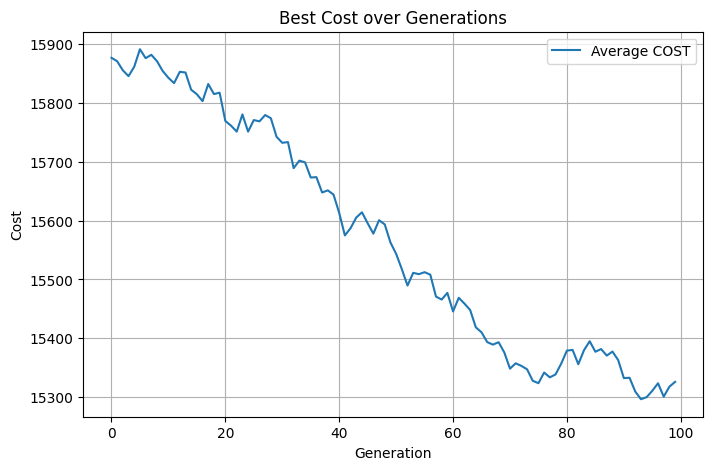

In [ ]:
import random

random.seed(64)

instance_name = 'C1_2_1'

unit_cost = 1.0
init_cost = 0.0
wait_cost = 0.0
delay_cost = 0

ind_size = 200
pop_size = 500
cx_pb = 0.9
mut_pb = 0.05
n_gen = 100

export_csv = True

run_gavrptw(instance_name=instance_name, unit_cost=unit_cost, init_cost=init_cost, \
    wait_cost=wait_cost, delay_cost=delay_cost, ind_size=ind_size, pop_size=pop_size, \
    cx_pb=cx_pb, mut_pb=mut_pb, n_gen=n_gen, export_csv=export_csv)


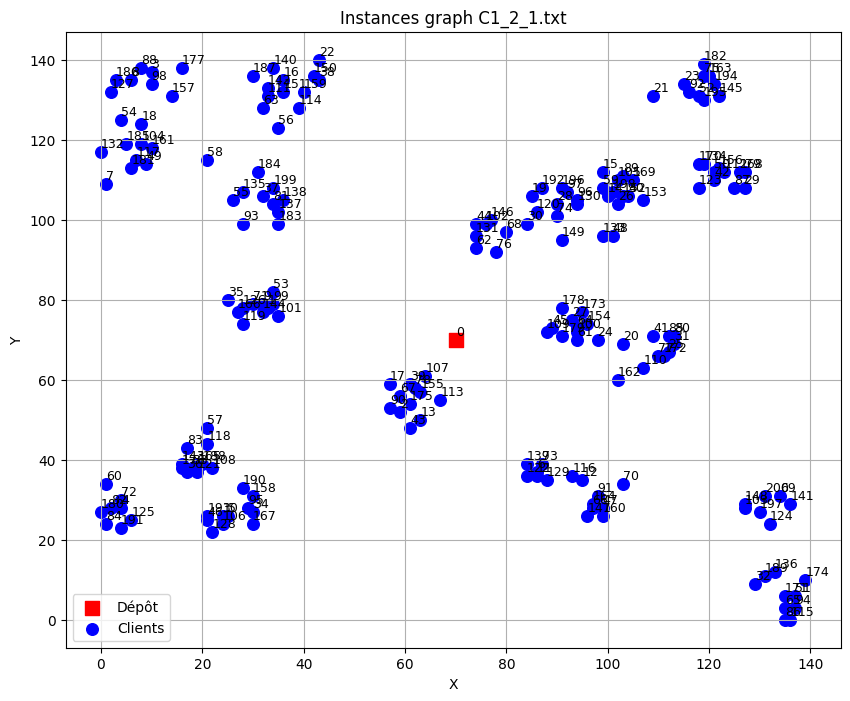

In [76]:
import vrplib
import os
import matplotlib.pyplot as plt

instance_name = "C1_2_1.txt"
instance_path = os.path.join("..", "instances", instance_name)

data = vrplib.read_instance(instance_path, instance_format="solomon")

coords = data['node_coord']
x = [c[0] for c in coords]
y = [c[1] for c in coords]

plt.figure(figsize=(10, 8))

plt.scatter(x[0], y[0], c='red', s=100, label='Dépôt', marker='s')
plt.scatter(x[1:], y[1:], c='blue', s=70, label='Clients')

for i, (xi, yi) in enumerate(coords):
    plt.text(xi, yi+1, str(i), fontsize=9)

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"Instances graph {instance_name}")
plt.legend()
plt.grid(True)
plt.show()


{'routes': [[34, 134, 25, 121, 192, 199, 129], [38, 31, 189, 104, 32, 170], [193, 120, 103, 69, 68, 145, 18], [198, 173, 12, 85, 194, 146, 111, 177, 178], [5, 157, 81, 163, 149, 36, 73, 27], [106, 185, 40, 116, 171, 197, 99], [191, 4, 53, 165, 154, 58, 190], [156, 44, 11, 29, 117, 130, 86], [70, 122, 196, 93, 151, 17, 45, 187, 9], [83, 160, 6, 97, 24, 162, 57, 188, 2], [10, 200, 66, 33, 90, 123, 59, 79], [43, 161, 148, 176, 109, 46], [22, 195, 167, 78, 47, 37, 14], [164, 136, 60, 135, 7, 30, 54, 183], [26, 100, 3, 84, 48, 64, 13, 133], [181, 138, 39, 55, 128, 174, 49], [186, 75, 74, 42, 61, 182, 96, 113], [132, 127, 56, 51, 20, 67, 172, 137], [50, 119, 115, 102, 107, 21, 153, 19], [28, 155, 166, 23, 143, 80, 87], [1, 140, 71, 131, 65, 82, 94], [175, 76, 91, 8, 125, 72, 114, 142], [112, 88, 147, 16, 92, 89, 179], [150, 62, 63, 168, 169, 95, 35, 152], [184, 159, 118, 139, 126, 110, 101, 108], [52, 124, 158, 144, 77, 105, 41, 141], [15, 98, 180]], 'cost': 15502.7}


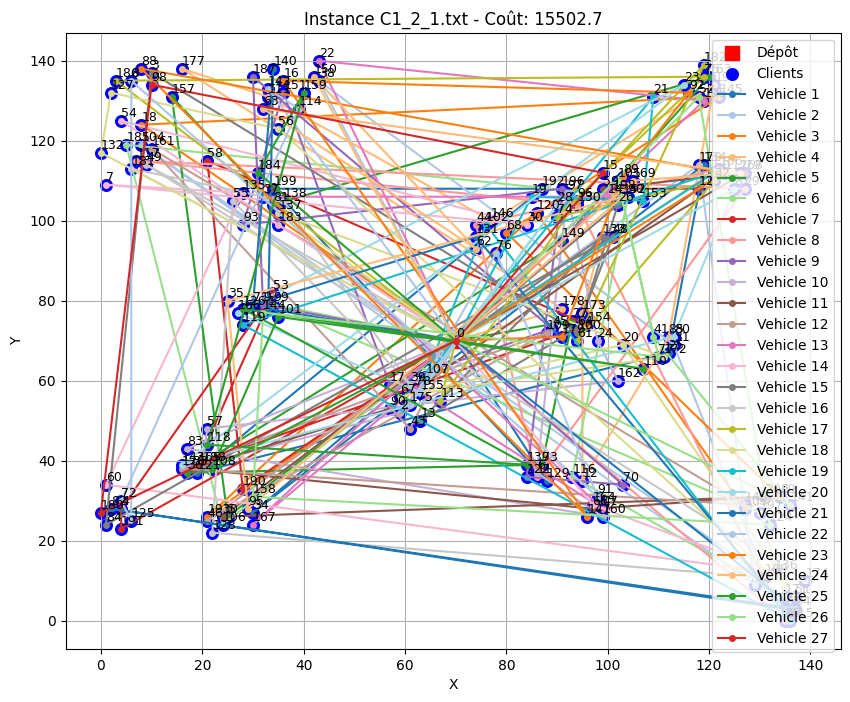

In [77]:
solution_path = os.path.join("..", "GA_Solutions", instance_name.replace(".txt", ".sol"))
solution = vrplib.read_solution(solution_path)

print(solution)


# Like before
coords = data['node_coord']
x = [c[0] for c in coords]
y = [c[1] for c in coords]

plt.figure(figsize=(10, 8))

plt.scatter(x[0], y[0], c='red', s=100, label='Dépôt', marker='s')
plt.scatter(x[1:], y[1:], c='blue', s=70, label='Clients')

for i, (xi, yi) in enumerate(coords):
    plt.text(xi, yi+1, str(i), fontsize=9)


# Drawing the trucks solutions
colors = plt.cm.tab20.colors

for i, route in enumerate(solution['routes']):
    full_route = [0] + route + [0]
    
    route_coords = [coords[node] for node in full_route]
    rx = [c[0] for c in route_coords]
    ry = [c[1] for c in route_coords]
    
    color = colors[i % len(colors)]
    plt.plot(rx, ry, '-o', color=color, label=f'Vehicle {i+1}', markersize=4, linewidth=1.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"Instance {instance_name} - Coût: {solution['cost']}")
plt.legend()
plt.grid(True)
plt.show()